In [ ]:
import pandas as pd
import numpy as np

import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
from gensim.models import Word2Vec

from sklearn.preprocessing import MinMaxScaler

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import tensorflow as tf

import matplotlib.pyplot as plt
from wordcloud import WordCloud

nlp = spacy.load("en_core_web_sm")

pd.set_option('display.max_colwidth', None)

df = pd.read_csv("twitter_parsed_dataset.csv")

In [30]:
df = df.drop(['id', 'index', 'oh_label'], axis=1)
df = df.dropna(subset=['Annotation'])
df = df.rename(columns={'Annotation': 'label', 'Text': 'text'})

In [31]:
df

,text,label
0,@halalflaws @biebervalue @greenlinerzjm I read them in context.No change in meaning. The history of Islamic slavery. https://t.co/xWJzpSodGj,none
1,@ShreyaBafna3 Now you idiots claim that people who tried to stop him from becoming a terrorist made him a terrorist. Islamically brain dead.,none
2,"RT @Mooseoftorment Call me sexist, but when I go to an auto place, I'd rather talk to a guy",sexism
3,"@g0ssipsquirrelx Wrong, ISIS follows the example of Mohammed and the Quran exactly.",racism
4,#mkr No No No No No No,none
...,...,...
16846,"Feeling so sorry for the girls, they should be safe and Kat and Andre should be going home #MKR",none
16847,"#MKR 'pretty good dishes we're happy with' - OK, well I'm never eating at your place.",none
16848,RT @colonelkickhead: Deconstructed lemon tart!....can we please go just one season of #MKR without someone calling something deconstructed.…,none
16849,@versacezaynx @nyazpolitics @greenlinerzjm You are too stupid to talk to. Blocked.,none


In [36]:
sia = SentimentIntensityAnalyzer()

# Function to get sentiment of a text
def get_sentiment(text):
    compound_score = sia.polarity_scores(text)['compound']
    return 'positive' if compound_score >= 0 else 'negative'


df['sentiment_label'] = df['text'].apply(get_sentiment)

## Preprocessing

In [42]:
df_prepro = df.copy()

def clean_text(text):
	# remove urls, mentions, hashtags, special characters, and RT
	text = re.sub(r'http\S+', '', text)
	text = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', text)
	text = re.sub(r'[^A-Za-z\s]', '', text)
	text = re.sub(r'\bRT\b', '', text)

	text = text.lower()

	# Remove stopwords
	#stop_words = set(stopwords.words('english'))
	#text_tokens = nltk.word_tokenize(text)
	#text = ' '.join([word for word in text_tokens if word not in stop_words])

	return text

df_prepro['text'] = df_prepro['text'].apply(clean_text)

#### The preprocessing of the text has to be refined based on the article + if we will use the some additional information, such as the emotion labels. I am also not sure if removing the stop words is a good idea (especially for SBERT embeddings)

In [43]:
df_prepro

,text,label,sentiment_label
0,i read them in contextno change in meaning the history of islamic slavery,none,negative
1,now you idiots claim that people who tried to stop him from becoming a terrorist made him a terrorist islamically brain dead,none,negative
2,call me sexist but when i go to an auto place id rather talk to a guy,sexism,positive
3,wrong isis follows the example of mohammed and the quran exactly,racism,negative
4,no no no no no no,none,positive
...,...,...,...
16846,feeling so sorry for the girls they should be safe and kat and andre should be going home,none,positive
16847,pretty good dishes were happy with ok well im never eating at your place,none,positive
16848,deconstructed lemon tartcan we please go just one season of without someone calling something deconstructed,none,positive
16849,you are too stupid to talk to blocked,none,negative


## Word Clouds

In [46]:
full_text = df_prepro['text'].values
racist_text = df_prepro[df_prepro['label'] == 'racism']['text'].values
sexist_text = df_prepro[df_prepro['label'] == 'sexism']['text'].values

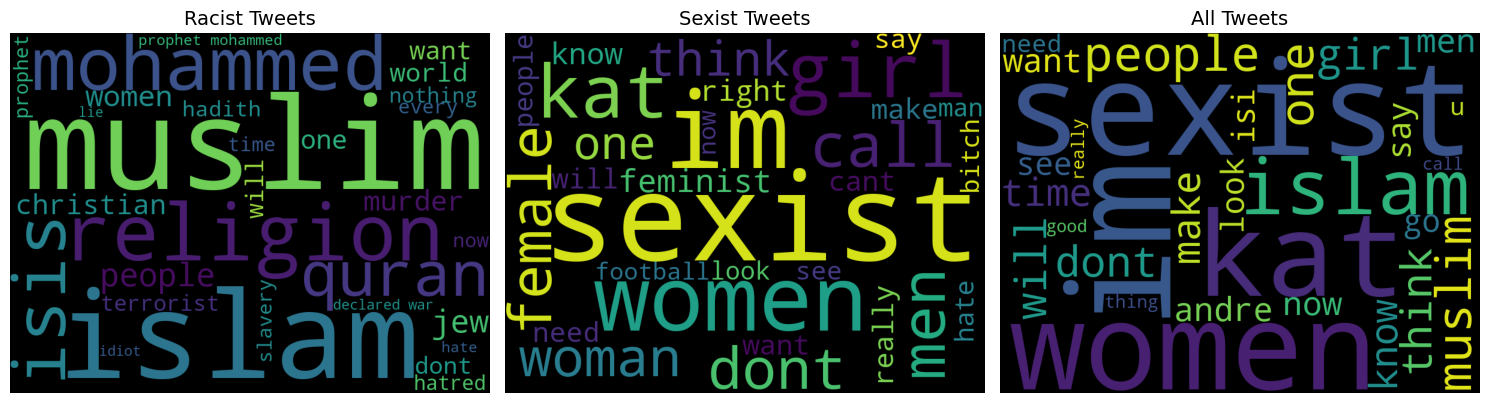

In [50]:
def generate_wordcloud(text):
    return WordCloud(
        background_color='black',
        width=800,  # Adjust size to fit
        height=600,
        max_words=30
    ).generate(" ".join(text))

racist_cloud = generate_wordcloud(racist_text)
sexist_cloud = generate_wordcloud(sexist_text)
full_cloud = generate_wordcloud(full_text)

# Plot them side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Titles for each subplot
titles = ["Racist Tweets", "Sexist Tweets", "All Tweets"]
clouds = [racist_cloud, sexist_cloud, full_cloud]

for ax, cloud, title in zip(axes, clouds, titles):
    ax.imshow(cloud)
    ax.set_title(title, fontsize=14, color="black") 
    ax.axis('off')

plt.tight_layout()
plt.show()

## Embedding : SBERT

In [51]:
df_sbert = df_prepro.copy()

In [53]:
df_sbert['embedding'] = df_sbert['text'].apply(lambda x: model.encode(x))

In [ ]:
df_sbert.to_pickle("df_sbert.pkl")

In [ ]:
df_sbert = pd.read_pickle("df_sbert.pkl")

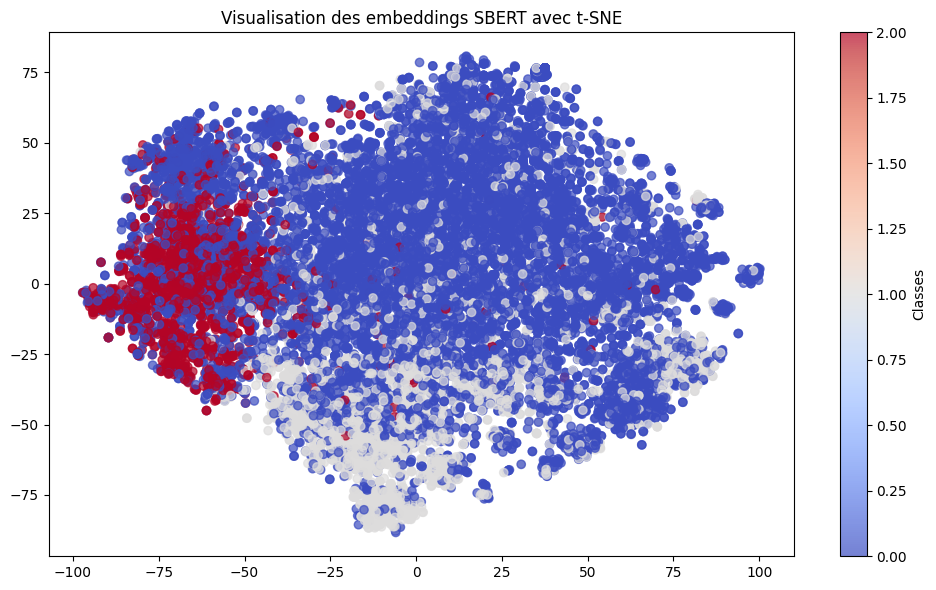

In [ ]:
# Charger les embeddings SBERT
embeddings = np.array(df_sbert['embedding'].tolist())  # Convertir la colonne en array
labels = df_sbert['label'].tolist()  # Récupérer les classes (None, Sexism, etc.)

# Réduction de dimension à 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualisation
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=[{'none':0, 'sexism':1, 'racism':2}[lbl] for lbl in labels], cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Classes")
plt.title("Visualisation des embeddings SBERT avec t-SNE")
plt.show()

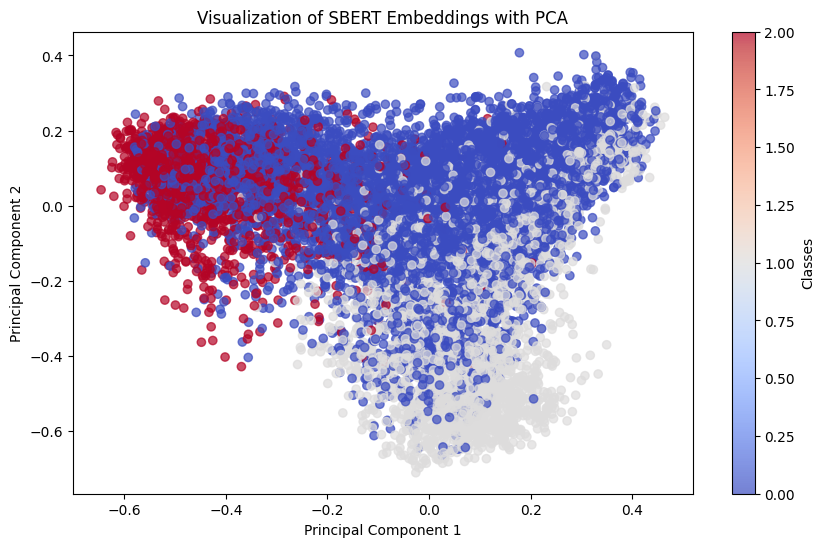

In [60]:
embeddings = np.array(df_sbert['embedding'].tolist())  # Convert column to NumPy array
labels = df_sbert['label'].tolist()  # Retrieve class labels

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], 
    c=[{'none': 0, 'sexism': 1, 'racism': 2}[lbl] for lbl in labels], 
    cmap='coolwarm', alpha=0.7
)

plt.colorbar(label="Classes")
plt.title("Visualization of SBERT Embeddings with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## Embedding : Word2Vec

In [62]:
df_w2c = df_prepro.copy()

text_list = df_w2c['text'].tolist()
annotations = df_w2c['label'].tolist()

In [64]:
w2v_model = Word2Vec(text_list, vector_size=300, window=5, min_count=5, workers=1)

# Fonction pour obtenir un embedding moyen par phrase
def sentence_to_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [65]:
sentence_vectors = []
labels = []

for sentence, label in zip(text_list, annotations):
    vector = sentence_to_vector(sentence, w2v_model)
    if vector is not None:  # Ensure valid vector
        sentence_vectors.append(vector)
        labels.append(label)

sentence_vectors = np.array(sentence_vectors)
labels = np.array(labels)

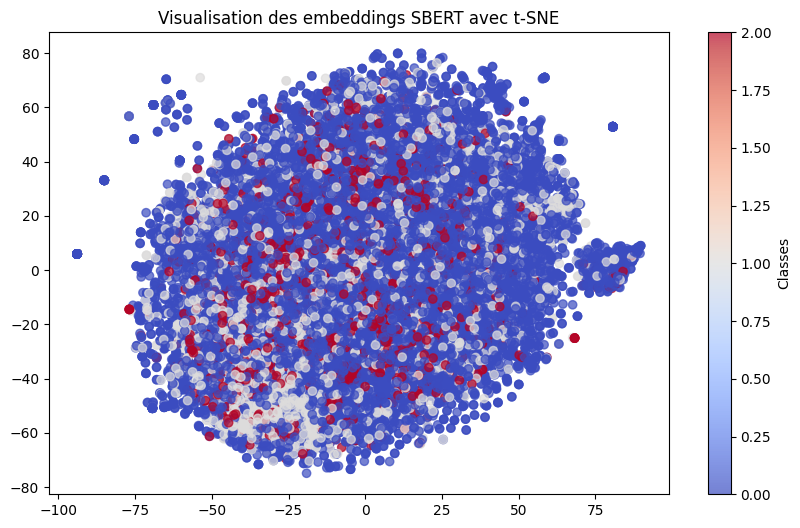

In [66]:
# Réduction de dimension à 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(sentence_vectors)

# Visualisation
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=[{'none':0, 'sexism':1, 'racism':2}[lbl] for lbl in labels], cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Classes")
plt.title("Visualisation des embeddings W2C avec t-SNE")
plt.show()

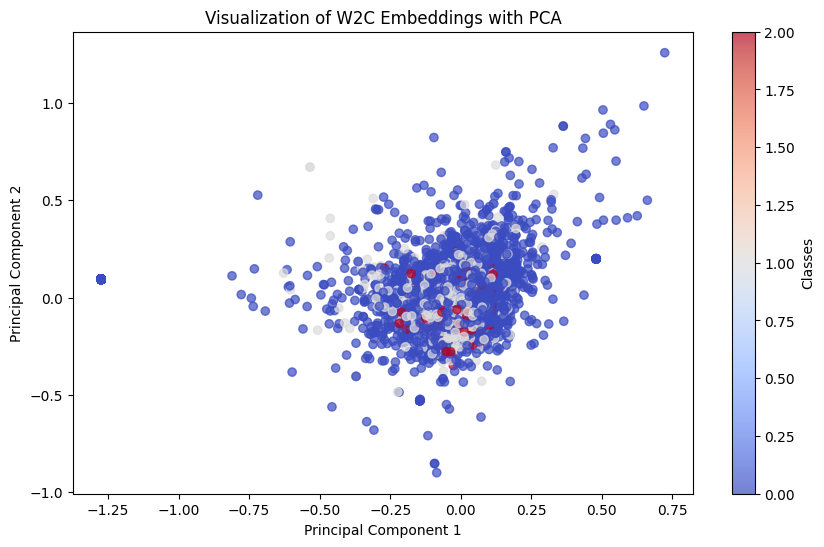

In [67]:
# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(sentence_vectors)

# Visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], 
    c=[{'none': 0, 'sexism': 1, 'racism': 2}[lbl] for lbl in labels], 
    cmap='coolwarm', alpha=0.7
)

plt.colorbar(label="Classes")
plt.title("Visualization of W2C Embeddings with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()